In [1]:
from time import perf_counter  

from modeling import build_models_from_csv
from bundles import BaseBundle, MSBundle
from utils import (
    tighten_bounds_one_model,
    MIN_DIST, ACTIVE_TOL, GAP_STOP_TOL,
)
from simplex_specialstart import run_pid_simplex_3d

# setup scenario number and target_nodes
csv_path       = "data.csv"
max_scenarios  = 10
target_nodes   = 100


bounds={
    "Kp": (-1, 0),
    "Ki": (-101, -99),
    "Kd": (0, 1),
    "x": (-2.5, 2.5),
    "u": (-5.0, 5.0),
    "e": (None, None),
    "I": (None, None),
}
bounds={
    "Kp": (-10.0, 10.0),
    "Ki": (-100.0, 100.0),
    "Kd": (-100.0, 1000.0),
    "x": (-2.5, 2.5),
    "u": (-5.0, 5.0),
    "e": (None, None),
    "I": (None, None),
}

weights = (10.0, 0.01)


# ====== stage 1：load data and generate models ======
T   = 15.0          
nfe = 20            

t_load0 = perf_counter()
model_list, first_stg_vars_list, m_tmpl_list, nfe = build_models_from_csv(
    csv_path=csv_path,
    T=T,
    nfe=nfe,
    weights=weights,
    bounds=bounds,
    sp0=0.0,
    sp1=0.5,
    tau_xs_col="tau_xs",
    tau_us_col="tau_us",
    tau_ds_col="tau_ds",          
    disturb_prefix="disturbance_",
    setpoint_change_col="setpoint_change",
    max_scenarios=max_scenarios,
    skip=0,
)
t_load1 = perf_counter()
print(f"[Time] Data load & scenario build: {t_load1 - t_load0:.3f}s")


# ====== stage 1.5：FBBT / OBBT ======
# same as snog: FBBT open,OBBT open
obbt_solver_opts = {
    "NonConvex": 2,
    "MIPGap": 1,     
    "TimeLimit": 15   
}
for m, yvars in zip(model_list, first_stg_vars_list):
    tighten_bounds_one_model(m, yvars,
                             use_fbbt=False,
                             use_obbt=False,
                             obbt_solver_name="gurobi",
                             obbt_solver_opts=obbt_solver_opts,
                             max_rounds=3, tol=1e-6, verbose=True)

# ====== stage 2: Persistent Solver Packaging ======
ub_options = {
    'NonConvex': 2,        
}
lb_options = {
    'NonConvex': 2,
    'MIPGap': 1e-1,            
    'TimeLimit': 15    
}

t_wrap0 = perf_counter()
base_bundles = [BaseBundle(m, ub_options) for m in model_list]  
ms_bundles   = [MSBundle(m, yvars, lb_options) for m, yvars in zip(model_list, first_stg_vars_list)]  # LB 侧
t_wrap1 = perf_counter()
print(f"[Time] Persistent wrapper (GurobiPersistent) setup: {t_wrap1 - t_wrap0:.3f}s")

# ====== stage 3：main loop ======
agg_bundle = None  

t_run0 = perf_counter()
hist = run_pid_simplex_3d(
    base_bundles=base_bundles,
    ms_bundles=ms_bundles,
    model_list=model_list,
    first_vars_list=first_stg_vars_list,
    target_nodes=target_nodes,
    min_dist=0,
    active_tol=ACTIVE_TOL,
    verbose=True,
    agg_bundle=agg_bundle,
    gap_stop_tol=1e-3,
    plot_every=2,
    use_exact_opt=False,
    exact_solver_name="gurobi",
    exact_solver_opts={"NonConvex": 2, "TimeLimit": 60},
    time_limit=60*10
)
t_run1 = perf_counter()
print(f"[Time] Main loop total: {t_run1 - t_run0:.3f}s")

# ====== print output ======
print("\n==== Done ====")
print(f"Total nodes: {len(hist['nodes'])}")
print(f"Best UB: {min(hist['UB_hist']) if hist['UB_hist'] else None}")
print(f"Last LB: {hist['LB_hist'][-1] if hist['LB_hist'] else None}")

[Time] Data load & scenario build: 0.192s
[Tighten] rounds=1, changed=False
[Tighten] rounds=1, changed=False
[Tighten] rounds=1, changed=False
[Tighten] rounds=1, changed=False
[Tighten] rounds=1, changed=False
[Tighten] rounds=1, changed=False
[Tighten] rounds=1, changed=False
[Tighten] rounds=1, changed=False
[Tighten] rounds=1, changed=False
[Tighten] rounds=1, changed=False
Set parameter WLSAccessID
Set parameter WLSSecret
Set parameter LicenseID to value 2689754
Academic license 2689754 - for non-commercial use only - registered to yi___@math.ubc.ca
Set parameter MIPGap to value 0.1
Set parameter NumericFocus to value 1
Set parameter Presolve to value 2
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.1
Set parameter NumericFocus to value 1
Set parameter Presolve to value 2
Set parameter NonConvex to value 2
Set parameter MIPGap to value 0.1
Set parameter NumericFocus to value 1
Set parameter Presolve to value 2
Set parameter NonConvex to value 2
Set parameter M

[Iter 0] evaluating Q for scenario 0
[Iter 0] evaluating Q for scenario 1
[Iter 0] evaluating Q for scenario 2
[BaseBundle.eval_at] Infeasible/Error for K=(-10.0, -19.367540137524593, 1000.0): status=warning, term=infeasibleOrUnbounded
[Iter 0] evaluating Q for scenario 3
[BaseBundle.eval_at] Infeasible/Error for K=(-10.0, -19.367540137524593, 1000.0): status=warning, term=infeasibleOrUnbounded
[Iter 0] evaluating Q for scenario 4
[BaseBundle.eval_at] Infeasible/Error for K=(-10.0, -19.367540137524593, 1000.0): status=warning, term=infeasibleOrUnbounded
[Iter 0] evaluating Q for scenario 5
[BaseBundle.eval_at] Infeasible/Error for K=(-10.0, -19.367540137524593, 1000.0): status=warning, term=infeasibleOrUnbounded
[Iter 0] evaluating Q for scenario 6
[BaseBundle.eval_at] Infeasible/Error for K=(-10.0, -19.367540137524593, 1000.0): status=warning, term=infeasibleOrUnbounded
[Iter 0] evaluating Q for scenario 7
[BaseBundle.eval_at] Infeasible/Error for K=(-10.0, -19.367540137524593, 1000.0

[Iter 2] evaluating Q for scenario 0
[Iter 2] evaluating Q for scenario 1
[Iter 2] evaluating Q for scenario 2
[Iter 2] evaluating Q for scenario 3
[Iter 2] evaluating Q for scenario 4
[Iter 2] evaluating Q for scenario 5
[Iter 2] evaluating Q for scenario 6
[Iter 2] evaluating Q for scenario 7
[Iter 2] evaluating Q for scenario 8
[Iter 2] evaluating Q for scenario 9

[Iter 2] Next Point Details:
Simplex   Scene   Type    As             ms             As+ms          Q              (Kp, Ki, Kd)                  
--------------------------------------------------------------------------------------------------------------------
T7        2       ms(dist)9.7885e+09     -9.7885e+09    5.4851e+00     8.5320e+00     (-9.5725, -99.9798, 18.6144)  

[Iter 2] subdivision type = interior (code=1) on simplex T7
[Iter 2] Elapsed: 22.950s
Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (win64 - Windows 10.0 (19045.2))

CPU model: Intel(R) Core(TM) i5-14400F, instruction set [SSE2|AVX|AVX2]
Thread 

In [2]:
timing = hist["timing"]
iter_ms_time = timing["iter_ms_time"]
iter_q_time = timing["iter_Q_new_time"]
iter_total_time = timing["iter_total_time"]

init_q_time = timing["init_Q_time"]
total_ms_time = sum(iter_ms_time)
total_q_time = sum(iter_q_time)
total_iter_time = sum(iter_total_time)

# ✅ NEW: Add c_s timing
total_cs_time = sum(sum(b.solve_const_time_hist) for b in ms_bundles)
total_subproblem_time = total_ms_time + total_cs_time

print(f"Init Q time:        {init_q_time:.3f} s")
print(f"Total MS time:      {total_ms_time:.3f} s")
print(f"Total c_s time:     {total_cs_time:.3f} s")
print(f"Total Q-new time:   {total_q_time:.3f} s")
print(f"Total iter runtime: {total_iter_time:.3f} s")
print(f"\nBreakdown:")
print(f"  MS subproblems:   {100.0 * total_ms_time / total_iter_time:.1f}%")
print(f"  c_s subproblems:  {100.0 * total_cs_time / total_iter_time:.1f}%")
print(f"  Q evaluations:    {100.0 * total_q_time / total_iter_time:.1f}%")
print(f"  Other overhead:   {100.0 * (1 - (total_ms_time + total_cs_time + total_q_time) / total_iter_time):.1f}%")

Init Q time:        0.051 s
Total MS time:      504.366 s
Total c_s time:     7.554 s
Total Q-new time:   0.098 s
Total iter runtime: 508.816 s

Breakdown:
  MS subproblems:   99.1%
  c_s subproblems:  1.5%
  Q evaluations:    0.0%
  Other overhead:   -0.6%


In [2]:

timing = hist["timing"]
iter_ms_time = timing["iter_ms_time"]
iter_q_time = timing["iter_Q_new_time"]
iter_total_time = timing["iter_total_time"]

init_q_time   = timing["init_Q_time"]
total_ms_time = sum(iter_ms_time)
total_q_time  = sum(iter_q_time)
total_iter_time = sum(iter_total_time)

print(f"Init Q time:        {init_q_time:.3f} s")
print(f"Total MS time:      {total_ms_time:.3f} s")
print(f"Total Q-new time:   {total_q_time:.3f} s")
print(f"Total iter runtime: {total_iter_time:.3f} s")
print(f"Share MS:           {100.0 * total_ms_time / total_iter_time:.1f}%")
print(f"Share Q-new:        {100.0 * total_q_time / total_iter_time:.1f}%")


Init Q time:        0.048 s
Total MS time:      91.333 s
Total Q-new time:   0.000 s
Total iter runtime: 91.517 s
Share MS:           99.8%
Share Q-new:        0.0%


In [3]:

iter_ms_times_detail = hist["iter_ms_times_detail"]
per_iter_ms_counts   = hist["per_iter_ms_counts"]

for it, per_scene_times in enumerate(iter_ms_times_detail):
    print(f"\nIter {it}:")

    iter_total_time = 0.0
    iter_total_calls = 0

    for s, times in enumerate(per_scene_times):
        scene_total = sum(times) if times else 0.0
        scene_calls = len(times)
        iter_total_time  += scene_total
        iter_total_calls += scene_calls

        row = [s] + [f"{dt:.2f}" for dt in times] + [f"sum={scene_total:.2f}"]
        print(row)

    expected_calls = per_iter_ms_counts[it]
    if expected_calls != iter_total_calls:
        print(f"[WARN] Iter {it}: 统计到的调用次数={iter_total_calls}，"
              f"per_iter_ms_counts={expected_calls}")

    print(f"Iter {it} total ms time = {iter_total_time:.2f}s, "
          f"total ms solves = {iter_total_calls}")



Iter 0:
[0, '15.02', '15.02', '15.02', '15.02', '15.02', '15.02', 'sum=90.10']
Iter 0 total ms time = 90.10s, total ms solves = 6

Iter 1:
[0, '15.02', '15.02', '15.02', 'sum=45.06']
Iter 1 total ms time = 45.06s, total ms solves = 3

Iter 2:
[0, '15.02', '15.02', 'sum=30.04']
Iter 2 total ms time = 30.04s, total ms solves = 2

Iter 3:
[0, '15.02', '15.02', '15.02', 'sum=45.06']
Iter 3 total ms time = 45.06s, total ms solves = 3

Iter 4:
[0, '15.02', '15.02', 'sum=30.03']
Iter 4 total ms time = 30.03s, total ms solves = 2

Iter 5:
[0, '15.01', '15.02', 'sum=30.03']
Iter 5 total ms time = 30.03s, total ms solves = 2

Iter 6:
[0, '15.02', '15.02', 'sum=30.04']
Iter 6 total ms time = 30.04s, total ms solves = 2

Iter 7:
[0, '15.03', '15.02', 'sum=30.04']
Iter 7 total ms time = 30.04s, total ms solves = 2

Iter 8:
[0, '15.02', '15.02', '15.02', '15.02', 'sum=60.08']
Iter 8 total ms time = 60.08s, total ms solves = 4

Iter 9:
[0, '15.02', '15.02', '15.02', 'sum=45.07']
Iter 9 total ms time

In [ ]:
# debug_constant_cut.py
import numpy as np
import pyomo.environ as pyo

from modeling import build_models_from_csv
from bundles import BaseBundle, MSBundle
from utils import evaluate_Q_at


def build_scenario_models(csv_path: str,
                          max_scenarios: int = 1,
                          skip: int = 0):
    """
    和主代码一致：用 build_models_from_csv 从 csv 构建场景模型。
    modeling.build_models_from_csv 的签名为：

        def build_models_from_csv(csv_path: str, h: float = 0.2,
                                  weights=(1.0, 0.01), bounds=None,
                                  sp0: float = 0.0, sp1: float = 0.5,
                                  ku_col: str = "tau_us",
                                  tau_col: str = "tau_xs",
                                  disturb_prefix: str = "disturbance_",
                                  setpoint_change_col: str = "setpoint_change",
                                  max_scenarios=None, skip=0):

    这里我们用默认的 h / weights / bounds，保证和原模型构建逻辑一致。
    """
    model_list, first_stg_vars_list, m_tmpl_list, T = build_models_from_csv(
        csv_path=csv_path,
        max_scenarios=max_scenarios,
        skip=skip,
    )
    return model_list, first_stg_vars_list, T


def debug_constant_cut_for_tetra(csv_path: str):
    # 1) 构建场景模型，只取场景 0
    print("=== 构建场景模型（从 CSV） ===")
    model_list, first_stg_vars_list, T = build_scenario_models(
        csv_path=csv_path,
        max_scenarios=1,
        skip=0,
    )
    m0 = model_list[0]
    first_vars0 = first_stg_vars_list[0]
    print(f"  已加载场景 0，时间步 T = {T}")
    print(f"  第一阶段变量个数 = {len(first_vars0)} "
          f"（应至少包含 Kp, Ki, Kd 三个）")

    # 2) 构建 BaseBundle，用来在 4 个顶点上求 Q_0
    print("\n=== 构建 BaseBundle，用于顶点上 Q_0 评估 ===")
    base_opts = {
        "NonConvex": 2,
        "MIPGap": 0.2,
        "TimeLimit": 600,   # 顶点评估给宽松一点
    }
    base_bundle0 = BaseBundle(m0, options=base_opts)

    # 3) 定义出错的四个顶点（给的是 (Kp, Ki, Kd)）
    print("\n=== 出错 tetra 的 4 个顶点（场景 0） ===")
    tet_vertices = [
        (-10.0,  100.0, 1000.0),  # v0
        (-10.0, -100.0, 1000.0),  # v1
        ( 10.0, -100.0, -100.0),  # v2
        (-10.0, -100.0, -100.0),  # v3
    ]
    for j, v in enumerate(tet_vertices):
        print(f"  v{j} = {v}")

    # 4) 在这 4 个顶点上分别求 Q_0(v_j)
    print("\n=== 在 4 个顶点上计算 Q_0 ===")
    fverts_scene0 = []
    for j, v in enumerate(tet_vertices):
        q_val = evaluate_Q_at(base_bundle0, first_vars0, v)
        fverts_scene0.append(q_val)
        print(f"  Q_0(v{j}) at K={v} -> {q_val:.6e}")

    fverts_scene0 = list(map(float, fverts_scene0))

    # 5) 构建 MSBundle，用来搭建带 lam 的子模型（和原 ms 完全同构）
    print("\n=== 构建 MSBundle（场景 0）并灌入 tetra ===")
    lb_options = {
        "NonConvex": 2,
        "MIPGap": 0.2,
        "TimeLimit": 15,    # 这就是你 ms / constant-cut 里用的 TimeLimit
    }
    ms_bundle0 = MSBundle(m0, first_vars0, options=lb_options)

    # update_tetra 会：
    #   - 把 link_kp/link_ki/link_kd 的系数改成对应的顶点坐标
    #   - 把 As_def 里的系数改成顶点上的 f_j = Q_s(v_j)
    ms_bundle0.update_tetra(tet_vertices, fverts_scene0)
    print("  已调用 ms_bundle.update_tetra(...)")

    # 6) 在 **同一个 clone 模型** 上改写目标函数为 constant-cut 版本：
    #    原来： obj = obj_expr - As
    #    现在： obj = obj_expr
    print("\n=== 在 MSBundle 的 clone 模型上改写目标为 constant-cut ===")
    m_cc = ms_bundle0.model  # 这是 clone + lam + link + As_def 的模型

    # 删除旧 obj，改成纯 obj_expr
    if hasattr(m_cc, "obj"):
        m_cc.del_component(m_cc.obj)
    m_cc.obj = pyo.Objective(expr=m_cc.obj_expr, sense=pyo.minimize)

    # 告诉 GurobiPersistent 新的目标
    ms_bundle0.gp.set_objective(m_cc.obj)

    # 7) 求解 constant-cut 模型，输出 Gurobi 日志和结果
    print("\n=== 求解 constant-cut 模型（K 在上述 tetra 内） ===")
    # 注意：GurobiPersistent 的参数在 MSBundle.__init__ 里已经设置过，
    # 这里直接 solve 即可；要看完整 log，就 tee=True。
    res = ms_bundle0.gp.solve(load_solutions=True, tee=True)

    status = res.solver.status
    term = res.solver.termination_condition
    obj_val = float(pyo.value(m_cc.obj))

    print("\n=== constant-cut 求解结果 ===")
    print(f"  solver.status              = {status}")
    print(f"  solver.termination_condition = {term}")
    print(f"  constant-cut objective Q_0  = {obj_val:.6e}")

    # 8) 打印一下 lam 和对应的 (Kp, Ki, Kd)，确认解确实在 tetra 内
    lam = np.array([pyo.value(m_cc.lam[j]) for j in m_cc.lam_index], dtype=float)
    print("\n=== barycentric 权重（lam）及其对应的 Kp,Ki,Kd ===")
    for j, val in enumerate(lam):
        print(f"  lam[{j}] = {val:.6e}")
    print(f"  sum(lam) = {lam.sum():.6e}")

    V = np.array(tet_vertices, dtype=float)
    K_opt = lam @ V
    print(f"\n  由 lam * V 得到的 K_opt = (Kp, Ki, Kd) = {tuple(map(float, K_opt))}")

    # 同时打印模型里 Kp/Ki/Kd 的值核对一下
    Kp_var = m_cc.find_component(first_vars0[0].name)
    Ki_var = m_cc.find_component(first_vars0[1].name)
    Kd_var = m_cc.find_component(first_vars0[2].name)
    print("  模型中变量取值：")
    print(f"    Kp = {float(pyo.value(Kp_var)):.6e}")
    print(f"    Ki = {float(pyo.value(Ki_var)):.6e}")
    print(f"    Kd = {float(pyo.value(Kd_var)):.6e}")


if __name__ == "__main__":
    # 这里改成你实际用的 CSV 文件名，比如 "data copy.csv"
    csv_path = "data.csv"
    debug_constant_cut_for_tetra(csv_path)


=== 构建场景模型（从 CSV） ===
  已加载场景 0，时间步 T = 20
  第一阶段变量个数 = 3 （应至少包含 Kp, Ki, Kd 三个）

=== 构建 BaseBundle，用于顶点上 Q_0 评估 ===
Set parameter MIPGap to value 0.2
Set parameter NumericFocus to value 1
Set parameter Presolve to value 2
Set parameter NonConvex to value 2
Set parameter TimeLimit to value 600

=== 出错 tetra 的 4 个顶点（场景 0） ===
  v0 = (-10.0, 100.0, 1000.0)
  v1 = (-10.0, -100.0, 1000.0)
  v2 = (10.0, -100.0, -100.0)
  v3 = (-10.0, -100.0, -100.0)

=== 在 4 个顶点上计算 Q_0 ===
  Q_0(v0) at K=(-10.0, 100.0, 1000.0) -> 1.397547e+00
model.name="unknown";
    - termination condition: infeasibleOrUnbounded
    - message from solver: <undefined>
  Q_0(v1) at K=(-10.0, -100.0, 1000.0) -> 1.397547e+00
  Q_0(v2) at K=(10.0, -100.0, -100.0) -> 4.186112e-01
  Q_0(v3) at K=(-10.0, -100.0, -100.0) -> 3.671763e-01

=== 构建 MSBundle（场景 0）并灌入 tetra ===
Set parameter MIPGap to value 0.2
Set parameter NumericFocus to value 1
Set parameter Presolve to value 2
Set parameter NonConvex to value 2
Set parameter TimeLim

In [ ]:
a = 0.7323830480978786
b = 0.6195866823895512
(a-b)/a

0.15401280245532506

In [ ]:
LB_hist = hist["LB_hist"]
lb_c_agg_hist = hist["lb_c_agg_hist"]
lb_c_per_scene_hist = hist["lb_c_per_scene_hist"]

for it, (lb, c_agg, c_scene) in enumerate(zip(LB_hist, lb_c_agg_hist, lb_c_per_scene_hist)):
    print(f"Iter {it:3d} | LB_global = {lb:.6f}")
    print(f"           c_agg (sum of finite c_s) = {c_agg:.6f}")
    print(f"           c_per_scene = {c_scene}")
    print()


Iter   0 | LB_global = 0.110240
           c_agg (sum of finite c_s) = 0.110240
           c_per_scene = [0.11024042469447069]

Iter   1 | LB_global = 0.110240
           c_agg (sum of finite c_s) = 0.110240
           c_per_scene = [0.11024042469447069]

Iter   2 | LB_global = 0.110240
           c_agg (sum of finite c_s) = 0.110240
           c_per_scene = [0.11024042469447069]

Iter   3 | LB_global = 0.110240
           c_agg (sum of finite c_s) = 0.110240
           c_per_scene = [0.11024042469447069]

Iter   4 | LB_global = 0.110240
           c_agg (sum of finite c_s) = 0.110240
           c_per_scene = [0.11024042469447069]

Iter   5 | LB_global = 0.110240
           c_agg (sum of finite c_s) = 0.110240
           c_per_scene = [0.11024042469447069]

Iter   6 | LB_global = 0.110240
           c_agg (sum of finite c_s) = 0.110240
           c_per_scene = [0.11024042469447069]

Iter   7 | LB_global = 0.110240
           c_agg (sum of finite c_s) = 0.110240
           c_per_scene =

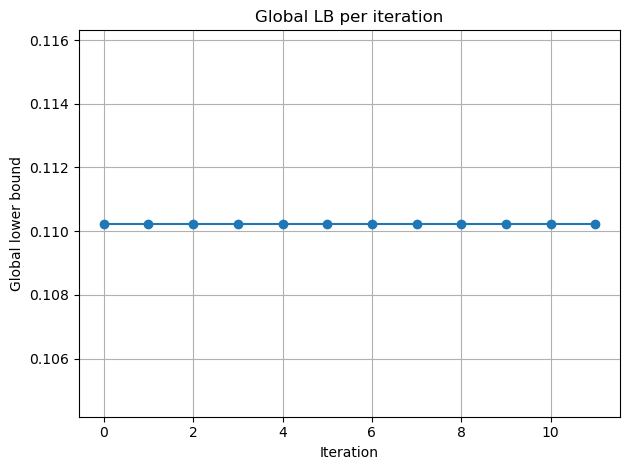

In [ ]:
import matplotlib.pyplot as plt

LB_hist = hist["LB_hist"]

plt.figure()
plt.plot(range(len(LB_hist)), LB_hist, marker="o")
plt.xlabel("Iteration")
plt.ylabel("Global lower bound")
plt.title("Global LB per iteration")
plt.grid(True)
plt.tight_layout()
plt.show()


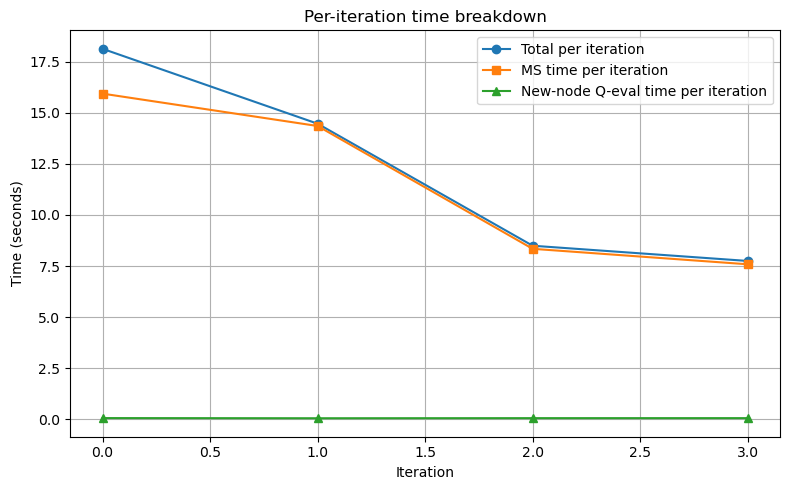

In [ ]:
import matplotlib.pyplot as plt

timing = hist["timing"]

iter_total_time = timing["iter_total_time"]
iter_ms_time    = timing["iter_ms_time"]
iter_q_time     = timing["iter_Q_new_time"]
iters = list(range(len(iter_total_time)))  # 0,1,2,...,n-1

plt.figure(figsize=(8, 5))

plt.plot(iters, iter_total_time, marker="o", label="Total per iteration")
plt.plot(iters, iter_ms_time,    marker="s", label="MS time per iteration")
plt.plot(iters, iter_q_time,     marker="^", label="New-node Q-eval time per iteration")

plt.xlabel("Iteration")
plt.ylabel("Time (seconds)")
# plt.yscale("log")

plt.title("Per-iteration time breakdown")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
init_q_time   = timing["init_Q_time"]
total_ms_time = sum(iter_ms_time)
total_q_time  = sum(iter_q_time)
total_iter_time = sum(iter_total_time)

print(f"Init Q time:        {init_q_time:.3f} s")
print(f"Total MS time:      {total_ms_time:.3f} s")
print(f"Total Q-new time:   {total_q_time:.3f} s")
print(f"Total iter runtime: {total_iter_time:.3f} s")
print(f"Share MS:           {100.0 * total_ms_time / total_iter_time:.1f}%")
print(f"Share Q-new:        {100.0 * total_q_time / total_iter_time:.1f}%")


Init Q time:        0.487 s
Total MS time:      69.770 s
Total Q-new time:   0.767 s
Total iter runtime: 72.508 s
Share MS:           96.2%
Share Q-new:        1.1%


In [ ]:
timing = hist["timing"]
per_iter_scene = timing["iter_ms_time_per_scene"]   # [iter][scene]

if not per_iter_scene:
    print("iter_ms_time_per_scene 是空的，没有记录到任何 ms 时间。")
else:
    num_iters = len(per_iter_scene)
    num_scenarios = len(per_iter_scene[0])

    # 打一行表头
    header = "Iter  total_ms  " + "  ".join(f"s{str(s).rjust(2)}" for s in range(num_scenarios))
    print(header)
    print("-" * len(header))

    for it, times_per_scene in enumerate(per_iter_scene):
        total_ms = sum(times_per_scene)
        # 每个场景的时间，保留 3 位小数
        scene_strs = [f"{t:7.3f}" for t in times_per_scene]
        line = f"{it:4d}  {total_ms:8.3f}  " + "  ".join(scene_strs)
        print(line)

Iter  total_ms  s 0
-------------------
   0     2.723    2.723
   1     1.846    1.846
   2     2.910    2.910
   3     3.385    3.385
   4     3.003    3.003
   5     2.670    2.670
   6     3.450    3.450
   7     4.474    4.474
   8    11.431   11.431
   9    11.532   11.532
  10    11.582   11.582
  11    10.498   10.498


In [ ]:
timing = hist["timing"]
calls_per_iter = timing["iter_ms_calls_per_scene"]   # [iter][scene]

num_iters = len(calls_per_iter)
S = len(ms_bundles)

if num_iters == 0:
    raise RuntimeError("iter_ms_calls_per_scene 是空的，说明你还没记录 per-scene 调用次数。")

# 防御性检查：timing 里的场景数要和 ms_bundles 一致
if len(calls_per_iter[0]) != S:
    raise RuntimeError(
        f"场景数不一致：timing 里是 {len(calls_per_iter[0])}，ms_bundles 里是 {S}"
    )

# offsets[s] 记录：场景 s 的 solve_time_hist 已经用到哪一条（前缀长度）
offsets = [0] * S

# 你想要的两个结果：
# iter_ms_times_detail[it][s] = list of dt for this iter & scene
iter_ms_times_detail: list[list[list[float]]] = []
# 每轮总共解了多少次 ms 子问题
per_iter_ms_counts: list[int] = []

for it in range(num_iters):
    calls_this_iter = calls_per_iter[it]   # 长度 S
    if len(calls_this_iter) != S:
        raise RuntimeError(f"第 {it} 轮 calls 的场景数不等于 S。")

    per_scene_times_this_iter: list[list[float]] = []
    total_calls_this_iter = 0

    for s in range(S):
        n_calls = calls_this_iter[s]
        start = offsets[s]
        end = start + n_calls

        # 从该场景的 solve_time_hist 中切出这一轮的那一段
        times_slice = ms_bundles[s].solve_time_hist[start:end]

        if len(times_slice) != n_calls:
            print(
                f"[WARN] iter {it}, scene {s}: "
                f"期待 {n_calls} 次，切出来 {len(times_slice)} 次"
            )

        per_scene_times_this_iter.append(list(times_slice))
        offsets[s] = end
        total_calls_this_iter += n_calls

    iter_ms_times_detail.append(per_scene_times_this_iter)
    per_iter_ms_counts.append(total_calls_this_iter)

# 全局计数 sanity check
total_from_counts = sum(per_iter_ms_counts)
total_from_hist = sum(len(b.solve_time_hist) for b in ms_bundles)

print(f"sum(per_iter_ms_counts)     = {total_from_counts}")
print(f"sum(len(b.solve_time_hist)) = {total_from_hist}")
if total_from_counts == total_from_hist:
    print("✅ 计数一致，还原 OK。")
else:
    print("⚠️ 计数不一致，说明 timing 或 solve_time_hist 有问题。")

sum(per_iter_ms_counts)     = 50
sum(len(b.solve_time_hist)) = 50
✅ 计数一致，还原 OK。


In [ ]:
for it, per_scene_times in enumerate(iter_ms_times_detail):
    print(f"\nIter {it}:")
    
    iter_total_time = 0.0      # 这一轮所有场景的总时间
    iter_total_calls = 0       # 这一轮总共求解了多少次 ms 子问题

    for s, times in enumerate(per_scene_times):
        scene_total = sum(times) if times else 0.0
        scene_calls = len(times)
        iter_total_time += scene_total
        iter_total_calls += scene_calls

        # 场景号 + 每次求解时间（两位小数）+ 该场景总时间
        row = [s] + [f"{dt:.2f}" for dt in times] + [f"sum={scene_total:.2f}"]
        print(row)

    # 如果你已经有 per_iter_ms_counts，也可以用它来核对：
    expected_calls = per_iter_ms_counts[it]
    if expected_calls != iter_total_calls:
        print(
            f"[WARN] Iter {it}: 统计到的调用次数={iter_total_calls}，"
            f"per_iter_ms_counts={expected_calls}"
        )

    # 这一轮所有场景的总时间 + 总调用次数
    print(f"Iter {it} total ms time = {iter_total_time:.2f}s, "
          f"total ms solves = {iter_total_calls}")


Iter 0:
[0, '0.06', '0.61', '0.62', '0.32', '0.32', '0.79', 'sum=2.72']
Iter 0 total ms time = 2.72s, total ms solves = 6

Iter 1:
[0, '0.59', '0.62', '0.31', '0.33', 'sum=1.85']
Iter 1 total ms time = 1.85s, total ms solves = 4

Iter 2:
[0, '0.68', '1.03', '0.49', '0.70', 'sum=2.91']
Iter 2 total ms time = 2.91s, total ms solves = 4

Iter 3:
[0, '0.78', '0.81', '1.06', '0.74', 'sum=3.38']
Iter 3 total ms time = 3.38s, total ms solves = 4

Iter 4:
[0, '0.61', '0.94', '0.49', '0.95', 'sum=3.00']
Iter 4 total ms time = 3.00s, total ms solves = 4

Iter 5:
[0, '0.62', '0.75', '0.50', '0.80', 'sum=2.67']
Iter 5 total ms time = 2.67s, total ms solves = 4

Iter 6:
[0, '1.35', '0.86', '0.64', '0.61', 'sum=3.45']
Iter 6 total ms time = 3.45s, total ms solves = 4

Iter 7:
[0, '0.90', '0.87', '0.83', '1.87', 'sum=4.47']
Iter 7 total ms time = 4.47s, total ms solves = 4

Iter 8:
[0, '5.05', '0.64', '5.05', '0.69', 'sum=11.43']
Iter 8 total ms time = 11.43s, total ms solves = 4

Iter 9:
[0, '5.05'

In [ ]:
for it, per_scene_times in enumerate(iter_ms_times_detail):
    print(f"\nIter {it}:")
    
    iter_total_time = 0.0      # 这一轮所有场景的总时间
    iter_total_calls = 0       # 这一轮总共求解了多少次 ms 子问题

    for s, times in enumerate(per_scene_times):
        scene_total = sum(times) if times else 0.0
        scene_calls = len(times)
        iter_total_time += scene_total
        iter_total_calls += scene_calls

        # 场景号 + 每次求解时间（两位小数）+ 该场景总时间
        row = [s] + [f"{dt:.2f}" for dt in times] + [f"sum={scene_total:.2f}"]
        print(row)

    # 如果你已经有 per_iter_ms_counts，也可以用它来核对：
    expected_calls = per_iter_ms_counts[it]
    if expected_calls != iter_total_calls:
        print(
            f"[WARN] Iter {it}: 统计到的调用次数={iter_total_calls}，"
            f"per_iter_ms_counts={expected_calls}"
        )

    # 这一轮所有场景的总时间 + 总调用次数
    print(f"Iter {it} total ms time = {iter_total_time:.2f}s, "
          f"total ms solves = {iter_total_calls}")




Iter 0:
[0, '0.06', '0.61', '0.62', '0.32', '0.32', '0.79', 'sum=2.72']
Iter 0 total ms time = 2.72s, total ms solves = 6

Iter 1:
[0, '0.59', '0.62', '0.31', '0.33', 'sum=1.85']
Iter 1 total ms time = 1.85s, total ms solves = 4

Iter 2:
[0, '0.68', '1.03', '0.49', '0.70', 'sum=2.91']
Iter 2 total ms time = 2.91s, total ms solves = 4

Iter 3:
[0, '0.78', '0.81', '1.06', '0.74', 'sum=3.38']
Iter 3 total ms time = 3.38s, total ms solves = 4

Iter 4:
[0, '0.61', '0.94', '0.49', '0.95', 'sum=3.00']
Iter 4 total ms time = 3.00s, total ms solves = 4

Iter 5:
[0, '0.62', '0.75', '0.50', '0.80', 'sum=2.67']
Iter 5 total ms time = 2.67s, total ms solves = 4

Iter 6:
[0, '1.35', '0.86', '0.64', '0.61', 'sum=3.45']
Iter 6 total ms time = 3.45s, total ms solves = 4

Iter 7:
[0, '0.90', '0.87', '0.83', '1.87', 'sum=4.47']
Iter 7 total ms time = 4.47s, total ms solves = 4

Iter 8:
[0, '5.05', '0.64', '5.05', '0.69', 'sum=11.43']
Iter 8 total ms time = 11.43s, total ms solves = 4

Iter 9:
[0, '5.05'

In [ ]:
# 假设你先跑了一遍：
# res = run_pid_simplex_3d(...)
iter_q_times_detail = hist["iter_q_times_detail"]
per_iter_q_counts   = hist["per_iter_q_counts"]

for it, per_scene_times in enumerate(iter_q_times_detail):
    print(f"\n[Q_s] Iter {it}:")
    
    iter_total_time = 0.0      # 这一轮所有场景 Q_s 的总时间
    iter_total_calls = 0       # 这一轮总共求解了多少次 Q_s

    for s, times in enumerate(per_scene_times):
        scene_total = sum(times) if times else 0.0
        scene_calls = len(times)
        iter_total_time += scene_total
        iter_total_calls += scene_calls

        # 场景号 + 每次求解时间（两位小数）+ 该场景总时间
        row = [s] + [f"{dt:.2f}" for dt in times] + [f"sum={scene_total:.2f}"]
        print(row)

    # 如果你想核对 per_iter_q_counts，也可以这么用：
    expected_calls = per_iter_q_counts[it]
    if expected_calls != iter_total_calls:
        print(
            f"[WARN][Q_s] Iter {it}: 统计到的调用次数={iter_total_calls}，"
            f"per_iter_q_counts={expected_calls}"
        )

    # 这一轮所有场景的总时间 + 总调用次数
    print(f"[Q_s] Iter {it} total Q_s time = {iter_total_time:.2f}s, "
          f"total Q_s solves = {iter_total_calls}")



[Q_s] Iter 0:
[0, '0.07', 'sum=0.07']
[Q_s] Iter 0 total Q_s time = 0.07s, total Q_s solves = 1

[Q_s] Iter 1:
[0, '0.06', 'sum=0.06']
[Q_s] Iter 1 total Q_s time = 0.06s, total Q_s solves = 1

[Q_s] Iter 2:
[0, '0.07', 'sum=0.07']
[Q_s] Iter 2 total Q_s time = 0.07s, total Q_s solves = 1

[Q_s] Iter 3:
[0, '0.07', 'sum=0.07']
[Q_s] Iter 3 total Q_s time = 0.07s, total Q_s solves = 1

[Q_s] Iter 4:
[0, '0.07', 'sum=0.07']
[Q_s] Iter 4 total Q_s time = 0.07s, total Q_s solves = 1

[Q_s] Iter 5:
[0, '0.06', 'sum=0.06']
[Q_s] Iter 5 total Q_s time = 0.06s, total Q_s solves = 1

[Q_s] Iter 6:
[0, '0.03', 'sum=0.03']
[Q_s] Iter 6 total Q_s time = 0.03s, total Q_s solves = 1

[Q_s] Iter 7:
[0, '0.06', 'sum=0.06']
[Q_s] Iter 7 total Q_s time = 0.06s, total Q_s solves = 1

[Q_s] Iter 8:
[0, '0.07', 'sum=0.07']
[Q_s] Iter 8 total Q_s time = 0.07s, total Q_s solves = 1

[Q_s] Iter 9:
[0, '0.07', 'sum=0.07']
[Q_s] Iter 9 total Q_s time = 0.07s, total Q_s solves = 1

[Q_s] Iter 10:
[0, '0.06', 's

In [ ]:
for it in range(len(iter_ms_times_detail)):
    print(f"\n========== Iter {it} ==========")

    # --- 打印 ms 时间 ---
    ms_scene_times = iter_ms_times_detail[it]
    ms_total_time = sum(sum(ts) for ts in ms_scene_times)
    ms_total_calls = sum(len(ts) for ts in ms_scene_times)
    print("[ms] per-scene detail:")
    for s, times in enumerate(ms_scene_times):
        row = [s] + [f"{dt:.2f}" for dt in times] + [f"sum={sum(times):.2f}"]
        print(row)
    print(f"[ms] total time = {ms_total_time:.2f}s, total solves = {ms_total_calls}")

    # --- 打印 Q_s 时间 ---
    q_scene_times = iter_q_times_detail[it]
    q_total_time = sum(sum(ts) for ts in q_scene_times)
    q_total_calls = sum(len(ts) for ts in q_scene_times)
    print("[Q_s] per-scene detail:")
    for s, times in enumerate(q_scene_times):
        row = [s] + [f"{dt:.2f}" for dt in times] + [f"sum={sum(times):.2f}"]
        print(row)
    print(f"[Q_s] total time = {q_total_time:.2f}s, total solves = {q_total_calls}")

    print(f"[ms_tot/Q_s] ratio = {ms_total_time/q_total_time:.2f}, [ms_perscen/Q_s] ratio = {(ms_total_time*q_total_calls)/(q_total_time*ms_total_calls):.2f}")





========== Iter 0 ==========
[ms] per-scene detail:
[0, '0.06', '0.61', '0.62', '0.32', '0.32', '0.79', 'sum=2.72']
[ms] total time = 2.72s, total solves = 6
[Q_s] per-scene detail:
[0, '0.07', 'sum=0.07']
[Q_s] total time = 0.07s, total solves = 1
[ms_tot/Q_s] ratio = 37.97, [ms_perscen/Q_s] ratio = 6.33

========== Iter 1 ==========
[ms] per-scene detail:
[0, '0.59', '0.62', '0.31', '0.33', 'sum=1.85']
[ms] total time = 1.85s, total solves = 4
[Q_s] per-scene detail:
[0, '0.06', 'sum=0.06']
[Q_s] total time = 0.06s, total solves = 1
[ms_tot/Q_s] ratio = 29.91, [ms_perscen/Q_s] ratio = 7.48

========== Iter 2 ==========
[ms] per-scene detail:
[0, '0.68', '1.03', '0.49', '0.70', 'sum=2.91']
[ms] total time = 2.91s, total solves = 4
[Q_s] per-scene detail:
[0, '0.07', 'sum=0.07']
[Q_s] total time = 0.07s, total solves = 1
[ms_tot/Q_s] ratio = 41.82, [ms_perscen/Q_s] ratio = 10.46

========== Iter 3 ==========
[ms] per-scene detail:
[0, '0.78', '0.81', '1.06', '0.74', 'sum=3.38']
[ms] t